In [1]:
import os
from os import listdir
from os.path import isfile, join

import random
import numpy as np

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
# %matplotlib notebook 

from IPython.core.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

covid_images_path = os.path.join("images", "COVID-19") 
normal_images_path = os.path.join("images", "Normal")

covid_images = [os.path.join(covid_images_path, f) for f in listdir(covid_images_path) if isfile(join(covid_images_path, f))]
normal_images = [os.path.join(normal_images_path, f) for f in listdir(normal_images_path) if isfile(join(normal_images_path, f))]

print(f"Total covid_images: {len(covid_images)}")
print(f"Total normal_images: {len(normal_images)}")

Total covid_images: 88
Total normal_images: 88


# Showing samples of our x-ray dataset

In [157]:
def resize_image(img_array):
    img = Image.fromarray(img_array)
    img = img.resize((224, 224))
    return np.array(img)

def show_images(images, title=""):
    # images = [np.array(Image.open(img).convert('L')) for img in images]
    # images = [resize_image(img) for img in images]
    fig, ax = plt.subplots(1, len(images), figsize=(15, 15), dpi=100)   
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='summer')
        ax[i].set_title(title)
    [x.axis('off') for x in ax]
    plt.show()
    
def convert_images(image_paths):
    images = [np.array(Image.open(img).convert('RGB')) for img in image_paths]
    images = [resize_image(img) for img in images]
    return np.array(images)

## Load and resize our images

In [158]:
covid_image_arrs = convert_images(covid_images)
normal_image_arrs = convert_images(normal_images)

print(f"covid_image_arrs: {covid_image_arrs.shape}")
print(f"normal_image_arrs: {normal_image_arrs.shape}")

covid_image_arrs: (88, 224, 224, 3)
normal_image_arrs: (88, 224, 224, 3)


## Showing random x-rays

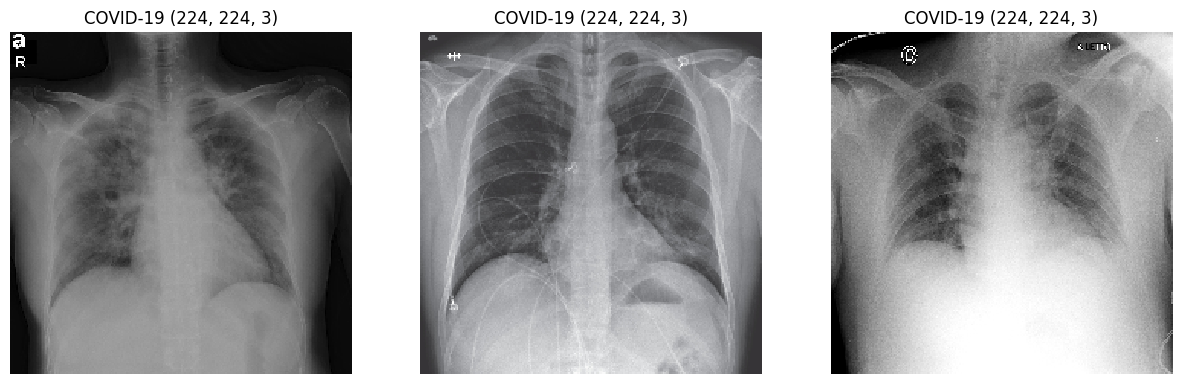

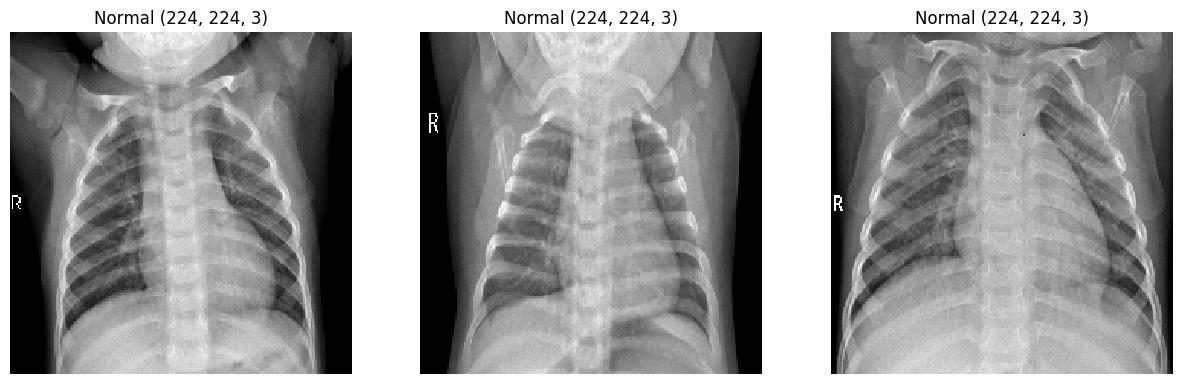

In [4]:
# Show random images that has COVID-19
show_images(random.sample(list(covid_image_arrs), 3), f"COVID-19 {covid_image_arrs[0].shape}")

# Show random images that are Normal
show_images(random.sample(list(normal_image_arrs), 3), f"Normal {normal_image_arrs[0].shape}")

# Create Data Generator

## Train / test split    

In [159]:
from sklearn.model_selection import train_test_split
import cv2

# 70:30 split on our dataset
train_size = int(len(covid_image_arrs) * 0.7)
test_size = len(covid_image_arrs) - train_size

# creating labels [COVID-19, Normal]
labels = ["COVID-19", "Normal"]
y1 = [[1., 0.] for i in range(len(covid_image_arrs))]
y2 = [[0., 1.] for i in range(len(normal_image_arrs))]

# splitting our data equally from each class
cX_train, cX_test, cy_train, cy_test = train_test_split(covid_image_arrs, y1, test_size=0.33, random_state=42)
nX_train, nX_test, ny_train, ny_test = train_test_split(normal_image_arrs, y2, test_size=0.33, random_state=42)

# combining both of the classes 
X_train = np.concatenate((cX_train, nX_train), axis=0)
X_test = np.concatenate((cX_test, nX_test), axis=0)
y_train = np.concatenate((cy_train, ny_train), axis=0)
y_test = np.concatenate((cy_test, ny_test), axis=0)

# preparing our test data
shuffle_list = list(range(len(X_test)))
random.shuffle(shuffle_list)

shufX_test = []
shufy_test = []

for i in shuffle_list:
    shufX_test.append(X_test[i])
    shufy_test.append(y_test[i])

X_test = np.array(shufX_test)
y_test = np.array(shufy_test)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (116, 224, 224, 3), y_train: (116, 2)
X_test: (60, 224, 224, 3), y_test: (60, 2)


## How our labels will look like
[COVID-19, Normal]

[1, 0] => Positive classify for COVID-19

[0, 1] => Negative classify for COVID-19

In [6]:
print(y_test[:5])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


# Creating our Data Generator

Data generator uses following techniques to augment images.
- <b>Histogram equalization</b>
    - This normalise the contrast of the image makes image more clear in darker areas
- <b>Image augmentation</b>
    - Image augmentation create more training samples for our model as our data set is very small

In [160]:
class data_generator:
    
    def create_train(self, train_set, test_set, batch_size, is_augmented=False):
        shape = train_set.shape[1:]
        while True:
            random_indexes = np.random.choice(len(train_set), batch_size)
            batch_images = []
            batch_labels = []
            for idx in random_indexes:
                # getting image
                image = train_set[idx]
                # augment image
                image = self.augment(image)
                # image historgram equalization
                image = self.histogram_equalization(image)
                # image denoise 
                # image = cv2.medianBlur(image, 3)
                # image normalization
                image = np.divide(image, 255)
                batch_images.append(image)
                
                # getting label
                label = test_set[idx] 
                batch_labels.append(label)
            yield np.array(batch_images), np.array(batch_labels)
            
    def histogram_equalization(self, image):
        r,g,b = cv2.split(image)
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
        return np.stack((r,g,b), -1)
    
    def augment(self, image):                  # randomly process images to create more samples
        augment_seq = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_seq.augment_image(image)
        return image_aug

## Visualise our generated images

[1. 0.] COVID-19
[0. 1.] Normal
[1. 0.] COVID-19


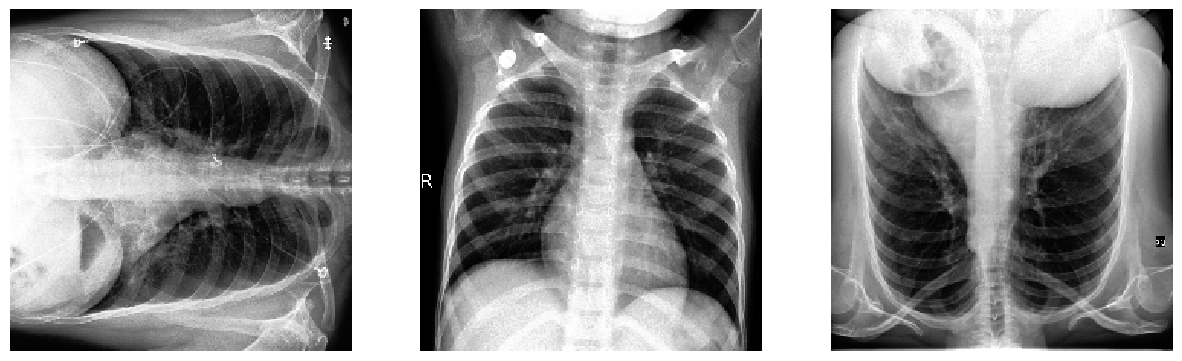

In [61]:
# testing our data generator
generator = data_generator()
train_gen = generator.create_train(X_train, y_train, 16)
batch_img, batch_label = next(train_gen)

# visualise generate images
for l in batch_label[:3]:
    print(l, labels[np.argmax(l)])
    
show_images(batch_img[:3])

# Building our Base Model

In [9]:
import tensorflow as tf

from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.applications import ResNet50V2, ResNet50

import warnings
warnings.filterwarnings('ignore')

In [53]:
def create_model(input_shape, n_out):
    pretrain_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in pretrain_model.layers:
        layer.trainable = False
    
    input_tensor = Input(shape=input_shape)
    
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(input_tensor)
    x = Conv2D(64, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

<b> Transfer Learning </b>
    
We create our model by using a freeze ResNet50V2 trained from imagenet. We then add couple of layers to learn from the features from ResNet50V2.

Take note that our trainable params is much smaller than the total params.

In [34]:
model = create_model(X_train.shape[1:], 2)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          131136    
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                100384    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0   

In [163]:
batch_size = 40
model_path = os.path.join("weights", "covid19_weights_before.hd5")

checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

data_gen = data_generator()
train_gen = data_gen.create_train(X_train, y_train, batch_size)
test_gen = data_gen.create_train(X_test, y_test, batch_size)

In [36]:
# opt = SGD(lr=1e-3, momentum=0.9)
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit_generator(train_gen,
                             steps_per_epoch=len(X_train) // batch_size,
                             validation_data=next(test_gen),
                             validation_steps=len(y_test) // batch_size,
                             epochs=100,
                             verbose=1,
                             callbacks=[checkPoint, reduceLROnPlato, earlyStop])

Epoch 1/100
2/2 [==============================] - 2s 1s/step - loss: 3.1800 - accuracy: 0.4250 - val_loss: 2.9494 - val_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 2.94940, saving model to weights/covid19_weights_before.hd5
Epoch 2/100
2/2 [==============================] - 0s 216ms/step - loss: 2.4296 - accuracy: 0.4750 - val_loss: 2.2227 - val_accuracy: 0.4000

Epoch 00002: val_loss improved from 2.94940 to 2.22273, saving model to weights/covid19_weights_before.hd5
Epoch 3/100
2/2 [==============================] - 0s 227ms/step - loss: 1.3762 - accuracy: 0.6500 - val_loss: 1.6570 - val_accuracy: 0.4500

Epoch 00003: val_loss improved from 2.22273 to 1.65698, saving model to weights/covid19_weights_before.hd5
Epoch 4/100
2/2 [==============================] - 0s 228ms/step - loss: 1.6666 - accuracy: 0.6000 - val_loss: 1.3406 - val_accuracy: 0.5000

Epoch 00004: val_loss improved from 1.65698 to 1.34055, saving model to weights/covid19_weights_before.hd5
Epoch 5/100

Epoch 34/100
2/2 [==============================] - 0s 231ms/step - loss: 0.7119 - accuracy: 0.6750 - val_loss: 0.5581 - val_accuracy: 0.6250

Epoch 00034: val_loss improved from 0.56443 to 0.55814, saving model to weights/covid19_weights_before.hd5
Epoch 35/100
2/2 [==============================] - 0s 209ms/step - loss: 0.6617 - accuracy: 0.6750 - val_loss: 0.5517 - val_accuracy: 0.6250

Epoch 00035: val_loss improved from 0.55814 to 0.55168, saving model to weights/covid19_weights_before.hd5
Epoch 36/100
2/2 [==============================] - 0s 230ms/step - loss: 0.7166 - accuracy: 0.6000 - val_loss: 0.5458 - val_accuracy: 0.6250

Epoch 00036: val_loss improved from 0.55168 to 0.54584, saving model to weights/covid19_weights_before.hd5
Epoch 37/100
2/2 [==============================] - 0s 235ms/step - loss: 0.4764 - accuracy: 0.8375 - val_loss: 0.5410 - val_accuracy: 0.6250

Epoch 00037: val_loss improved from 0.54584 to 0.54096, saving model to weights/covid19_weights_before.hd5


Epoch 67/100
2/2 [==============================] - 0s 241ms/step - loss: 0.2177 - accuracy: 0.8875 - val_loss: 0.4297 - val_accuracy: 0.8000

Epoch 00067: val_loss improved from 0.43141 to 0.42967, saving model to weights/covid19_weights_before.hd5
Epoch 68/100
2/2 [==============================] - 0s 218ms/step - loss: 0.3651 - accuracy: 0.8875 - val_loss: 0.4290 - val_accuracy: 0.7750

Epoch 00068: val_loss improved from 0.42967 to 0.42897, saving model to weights/covid19_weights_before.hd5
Epoch 69/100
2/2 [==============================] - 0s 233ms/step - loss: 0.4309 - accuracy: 0.8125 - val_loss: 0.4274 - val_accuracy: 0.7750

Epoch 00069: val_loss improved from 0.42897 to 0.42741, saving model to weights/covid19_weights_before.hd5
Epoch 70/100
2/2 [==============================] - 0s 226ms/step - loss: 0.3616 - accuracy: 0.8000 - val_loss: 0.4251 - val_accuracy: 0.8000

Epoch 00070: val_loss improved from 0.42741 to 0.42513, saving model to weights/covid19_weights_before.hd5


In [14]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

<b> Training loss and Training accuracy </b>

Below shows that our model doesn't overfit, no gaps or sudden gain validation loss.

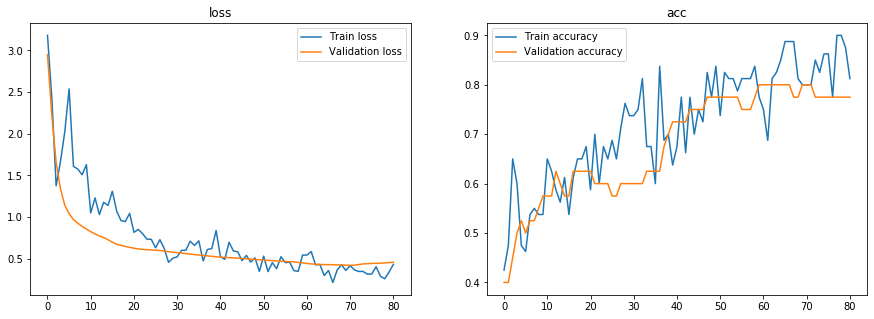

In [39]:
show_history(history)

# Evaluating Base Model

Looking at confusion matrix and classification report.

<img style="float: left;" src="images/confusion_matrix.png">



In [48]:
# Load model
# model = load_model(os.path.join("weights", "covid19_weights_before.hd5"))

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

predict_idxs = model.predict(X_test, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), predict_idxs)
print(cm)

[[30  0]
 [25  5]]


From above confusion matrix we can see that FN is very high. This means there are positive case goes undetected.

From the bottom we can also see that model have difficulty identify healthy X-Ray scans.

In [41]:
print(classification_report(np.argmax(y_test, axis=1), predict_idxs, target_names=labels))

              precision    recall  f1-score   support

    COVID-19       0.55      1.00      0.71        30
      Normal       1.00      0.17      0.29        30

    accuracy                           0.58        60
   macro avg       0.77      0.58      0.50        60
weighted avg       0.77      0.58      0.50        60



# Attempt to improve on base model

We attempt to train the mode using FastAI techniques using Cyclic Learning Rate.

This technique prevent us from getting stuck in local minimal.

In [15]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *
import numpy as np
import keras

class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [16]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    """
    Up-to date version: https://github.com/WittmannF/LRFinder
    Example of usage:
        from keras.models import Sequential
        from keras.layers import Flatten, Dense
        from keras.datasets import fashion_mnist
        !git clone https://github.com/WittmannF/LRFinder.git
        from LRFinder.keras_callback import LRFinder
        # 1. Input Data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        mean, std = X_train.mean(), X_train.std()
        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std
        # 2. Define and Compile Model
        model = Sequential([Flatten(),
                            Dense(512, activation='relu'),
                            Dense(10, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'], optimizer='sgd')
        # 3. Fit using Callback
        lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
        model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)
    """
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

## Find learning rate for this model

Epoch 1/100
2/2 [==============================] - 4s 2s/step - loss: 1.6023 - accuracy: 0.5500 - val_loss: 1.5969 - val_accuracy: 0.5250

Epoch 00001: val_loss did not improve from 0.58086
Epoch 2/100
2/2 [==============================] - 0s 226ms/step - loss: 1.7345 - accuracy: 0.5875 - val_loss: 1.5934 - val_accuracy: 0.5250

Epoch 00002: val_loss did not improve from 0.58086
Epoch 3/100
2/2 [==============================] - 1s 273ms/step - loss: 1.7121 - accuracy: 0.5125 - val_loss: 1.5981 - val_accuracy: 0.5250

Epoch 00003: val_loss did not improve from 0.58086
Epoch 4/100
2/2 [==============================] - 0s 231ms/step - loss: 1.8674 - accuracy: 0.4750 - val_loss: 1.5948 - val_accuracy: 0.5250

Epoch 00004: val_loss did not improve from 0.58086
Epoch 5/100
2/2 [==============================] - 0s 234ms/step - loss: 1.8543 - accuracy: 0.5250 - val_loss: 1.5915 - val_accuracy: 0.5250

Epoch 00005: val_loss did not improve from 0.58086
Epoch 6/100
2/2 [=====================

2/2 [==============================] - 1s 268ms/step - loss: 1.6655 - accuracy: 0.5250 - val_loss: 1.5981 - val_accuracy: 0.5250

Epoch 00043: val_loss did not improve from 0.58086
Epoch 44/100
2/2 [==============================] - 0s 233ms/step - loss: 1.6249 - accuracy: 0.5250 - val_loss: 1.4129 - val_accuracy: 0.5250

Epoch 00044: val_loss did not improve from 0.58086
Epoch 45/100
2/2 [==============================] - 0s 230ms/step - loss: 2.2568 - accuracy: 0.4000 - val_loss: 1.3460 - val_accuracy: 0.5250

Epoch 00045: val_loss did not improve from 0.58086
Epoch 46/100
2/2 [==============================] - 1s 272ms/step - loss: 1.4714 - accuracy: 0.5750 - val_loss: 1.3436 - val_accuracy: 0.5250

Epoch 00046: val_loss did not improve from 0.58086
Epoch 47/100
2/2 [==============================] - 0s 223ms/step - loss: 2.4337 - accuracy: 0.3625 - val_loss: 0.9460 - val_accuracy: 0.5500

Epoch 00047: val_loss did not improve from 0.58086
Epoch 48/100
2/2 [=========================

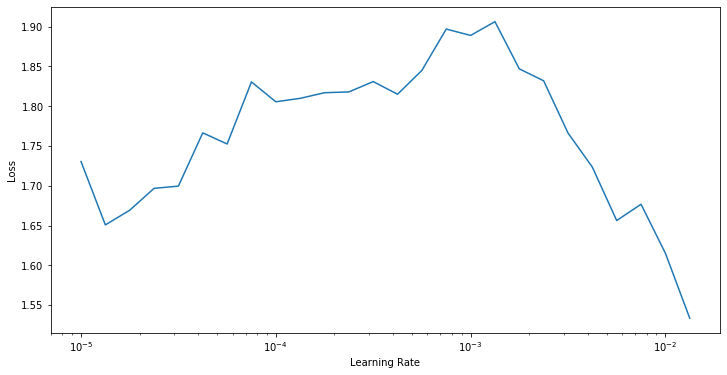

Epoch 00065: early stopping


In [25]:
# 2. Define and Compile Model
batch_size = 40
opt = SGD(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# 3. Fit using Callback
lr_finder = LRFinder(min_lr=1e-5, max_lr=1)

history = model.fit_generator(train_gen,
                             steps_per_epoch=len(X_train) // batch_size,
                             validation_data=next(test_gen),
                             validation_steps=len(y_test) // batch_size,
                             epochs=100,
                             verbose=1,
                             callbacks=[lr_finder, checkPoint, reduceLROnPlato, earlyStop])

Best learning rate is about <b>1e-2</b>, so let's use that.

## Train with Cyclic Learning Rate

In [52]:
opt = SGD(learning_rate=1e-4)

max_lr = 1e-2
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85
cyclical_momentum = True

clr =  CyclicLR(base_lr = base_lr,
                max_lr = max_lr,
                step_size = len(X_train) // batch_size,
                max_m = max_m,
                base_m = base_m,
                cyclical_momentum = cyclical_momentum)

model_path = os.path.join("weights", "covid19_weights_after.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# unfreeze layers
backbone_model = model.layers[1]
for layer in backbone_model.layers[-2:]:
    layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          131136    
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                100384    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0   

In [53]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=len(X_train) // batch_size,
                             validation_data=next(test_gen),
                             validation_steps=len(y_test) // batch_size,
                             epochs=100,
                             verbose=1,
                             callbacks=[clr, checkPoint, reduceLROnPlato, earlyStop])

Epoch 1/100
2/2 [==============================] - 4s 2s/step - loss: 0.4683 - accuracy: 0.7875 - val_loss: 0.3496 - val_accuracy: 0.8250

Epoch 00001: val_loss improved from inf to 0.34964, saving model to weights/covid19_weights_after.hd5
Epoch 2/100
2/2 [==============================] - 0s 243ms/step - loss: 0.4185 - accuracy: 0.8000 - val_loss: 0.4447 - val_accuracy: 0.7500

Epoch 00002: val_loss did not improve from 0.34964
Epoch 3/100
2/2 [==============================] - 1s 251ms/step - loss: 0.2014 - accuracy: 0.9000 - val_loss: 0.6895 - val_accuracy: 0.7250

Epoch 00003: val_loss did not improve from 0.34964
Epoch 4/100
2/2 [==============================] - 1s 252ms/step - loss: 0.2939 - accuracy: 0.8375 - val_loss: 1.0504 - val_accuracy: 0.7000

Epoch 00004: val_loss did not improve from 0.34964
Epoch 5/100
2/2 [==============================] - 1s 251ms/step - loss: 0.2052 - accuracy: 0.9250 - val_loss: 1.3347 - val_accuracy: 0.6750

Epoch 00005: val_loss did not improve 

In [57]:
from sklearn.metrics import confusion_matrix, classification_report
predict_idxs = model.predict(X_test, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), predict_idxs)
print(cm)

[[25  5]
 [ 4 26]]


In [58]:
print(classification_report(np.argmax(y_test, axis=1), predict_idxs, target_names=labels))

              precision    recall  f1-score   support

    COVID-19       0.86      0.83      0.85        30
      Normal       0.84      0.87      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



We gotten siginficate improvement from previous 0.58 accuracy.

Now we are at <b>0.85</b> accuracy but this is surely not good enough, can you do better?

# ?? Not sure why this works ??

In [170]:
def create_better_model(input_shape, n_out):
    """
    Attempt to build a better model, not sure why NOT adding pretrain model works better
    """    
    input_tensor = Input(shape=input_shape)
    
    x = AveragePooling2D(pool_size=(3, 3))(input_tensor)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

In [171]:
opt = Adam(learning_rate=1e-4)

model_path = os.path.join("weights", "improved_covid19_weights.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

model = create_better_model(X_train.shape[1:], 2)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
average_pooling2d_32 (Averag (None, 74, 74, 3)         0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 16428)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                1051456   
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 130       
Total params: 1,051,586
Trainable params: 1,051,586
Non-trainable params: 0
________________________________________________

In [172]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=len(X_train) // batch_size,
                             validation_data=next(test_gen),
                             validation_steps=len(y_test) // batch_size,
                             epochs=100,
                             verbose=1,
                             callbacks=[reduceLROnPlato, checkPoint, earlyStop])

Epoch 1/100
2/2 [==============================] - 1s 722ms/step - loss: 1.0531 - accuracy: 0.3750 - val_loss: 0.5961 - val_accuracy: 0.6750

Epoch 00001: val_loss improved from inf to 0.59613, saving model to weights/improved_covid19_weights.hd5
Epoch 2/100
2/2 [==============================] - 0s 64ms/step - loss: 0.7075 - accuracy: 0.6250 - val_loss: 0.5400 - val_accuracy: 0.7250

Epoch 00002: val_loss improved from 0.59613 to 0.53999, saving model to weights/improved_covid19_weights.hd5
Epoch 3/100
2/2 [==============================] - 0s 70ms/step - loss: 0.5926 - accuracy: 0.7250 - val_loss: 0.5528 - val_accuracy: 0.7000

Epoch 00003: val_loss did not improve from 0.53999
Epoch 4/100
2/2 [==============================] - 0s 64ms/step - loss: 0.5755 - accuracy: 0.6500 - val_loss: 0.4984 - val_accuracy: 0.8000

Epoch 00004: val_loss improved from 0.53999 to 0.49836, saving model to weights/improved_covid19_weights.hd5
Epoch 5/100
2/2 [==============================] - 0s 65ms/st

2/2 [==============================] - 0s 102ms/step - loss: 0.3996 - accuracy: 0.8125 - val_loss: 0.3714 - val_accuracy: 0.8750

Epoch 00037: val_loss did not improve from 0.30661
Epoch 38/100
2/2 [==============================] - 0s 99ms/step - loss: 0.4211 - accuracy: 0.8375 - val_loss: 0.3574 - val_accuracy: 0.8750

Epoch 00038: val_loss did not improve from 0.30661
Epoch 39/100
2/2 [==============================] - 0s 108ms/step - loss: 0.3132 - accuracy: 0.8625 - val_loss: 0.3055 - val_accuracy: 0.8500

Epoch 00039: val_loss improved from 0.30661 to 0.30552, saving model to weights/improved_covid19_weights.hd5
Epoch 40/100
2/2 [==============================] - 0s 118ms/step - loss: 0.4084 - accuracy: 0.8125 - val_loss: 0.3074 - val_accuracy: 0.8500

Epoch 00040: val_loss did not improve from 0.30552
Epoch 41/100
2/2 [==============================] - 0s 117ms/step - loss: 0.2916 - accuracy: 0.8750 - val_loss: 0.3138 - val_accuracy: 0.8250

Epoch 00041: val_loss did not improve

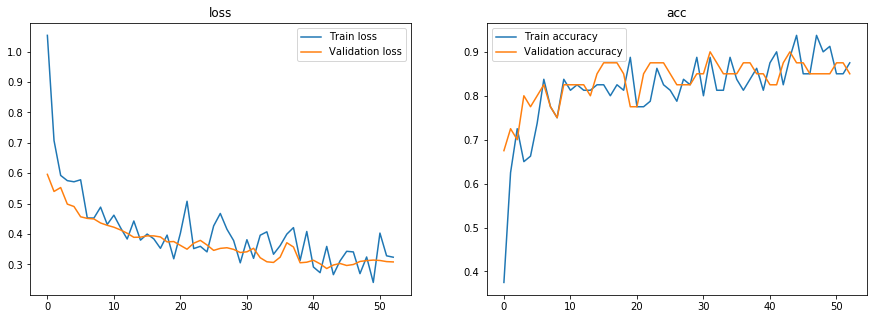

In [173]:
show_history(history)

## Evaluate our improved model

In [174]:
from sklearn.metrics import confusion_matrix, classification_report

predict_idxs = model.predict(X_test, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), predict_idxs)
print(cm)

[[30  0]
 [ 2 28]]


In [175]:
print(classification_report(np.argmax(shufy_test, axis=1), predict_idxs, target_names=labels))

              precision    recall  f1-score   support

    COVID-19       0.94      1.00      0.97        30
      Normal       1.00      0.93      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



# Export to HTML

In [177]:
!jupyter nbconvert classifier.ipynb --to html

[NbConvertApp] Converting notebook classifier.ipynb to html
[NbConvertApp] Writing 1469170 bytes to classifier.html
